### Gaussian process regression 1D

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.spatial import distance
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%matplotlib inline  
%config InlineBackend.figure_format='retina'
print ("Ready.")

Ready.


### Define a kernel function

In [2]:
def kernel_se(x1,x2,hyp={'gain':1.0,'len':1.0}):
    """
        Squared-exponential kernel function
    """
    D = distance.cdist(x1/hyp['len'],x2/hyp['len'],'sqeuclidean')
    K = hyp['gain']*np.exp(-D)
    return K
print ("Ready.")

Ready.


### 1D example
Note that `+-2std` corresponds to `95%` confidence interval.

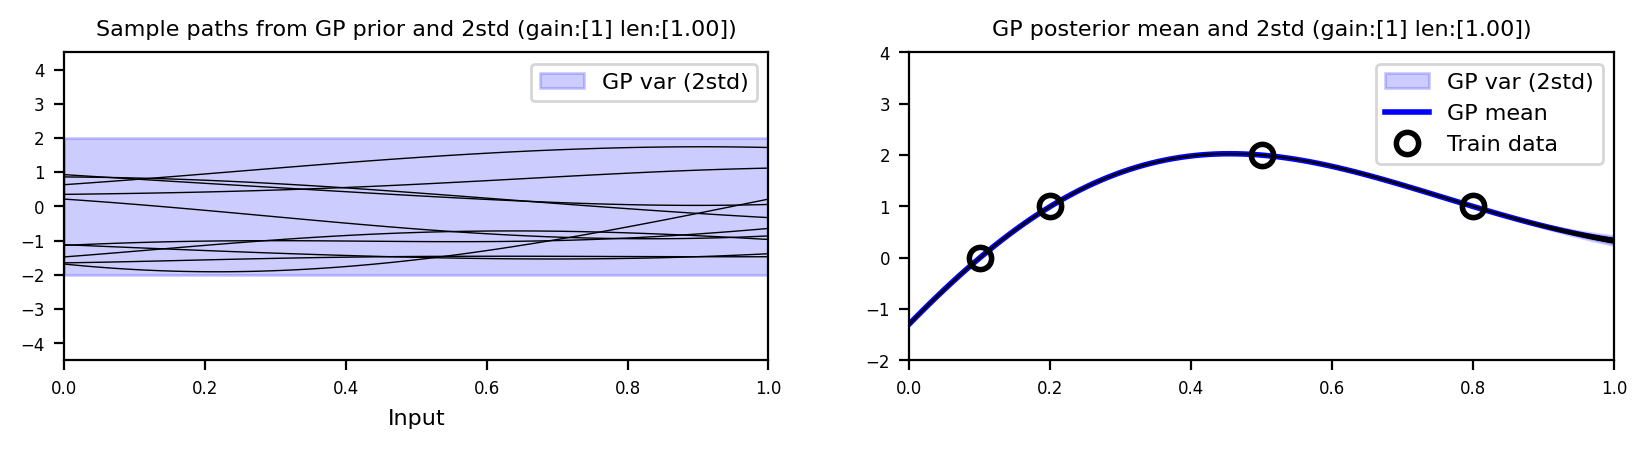

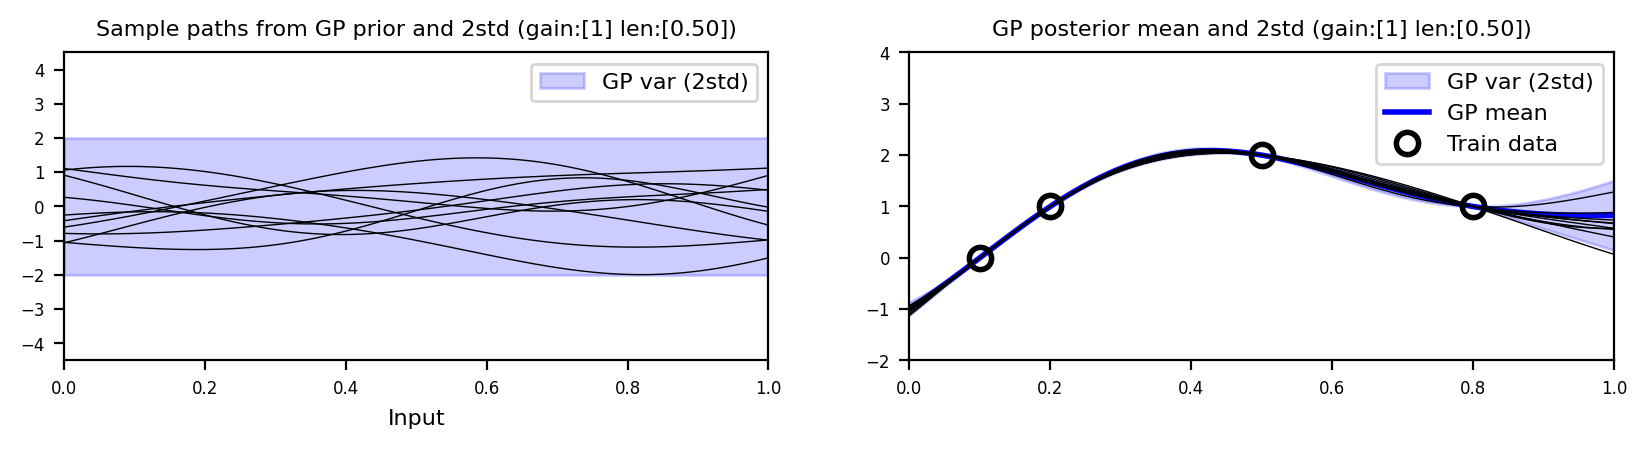

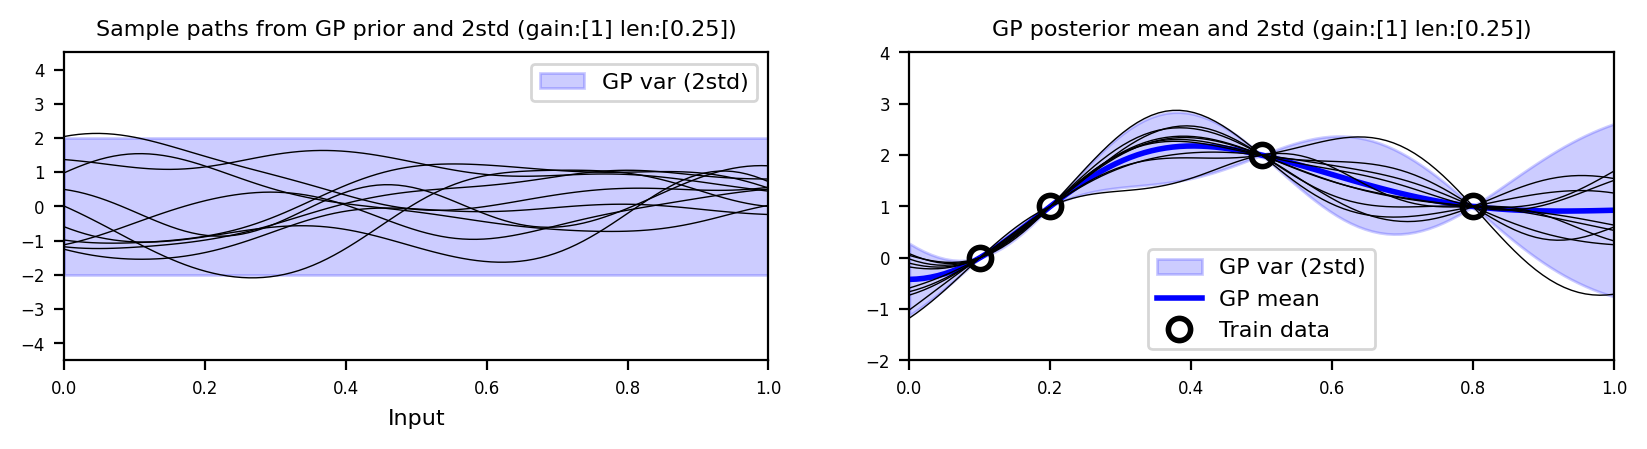

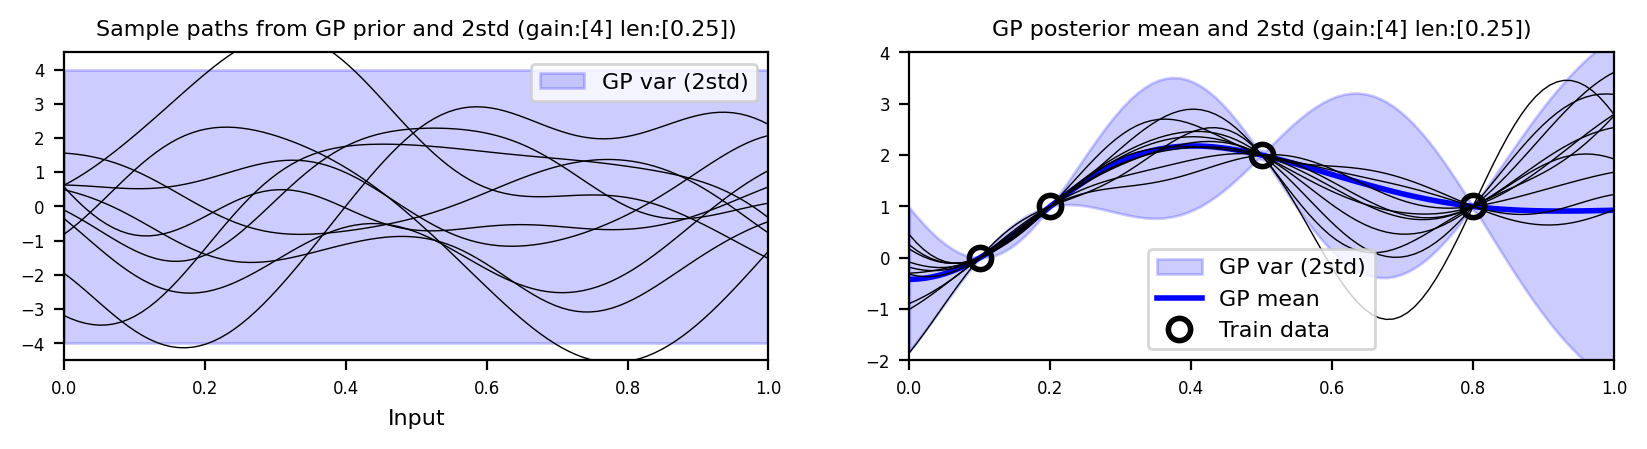

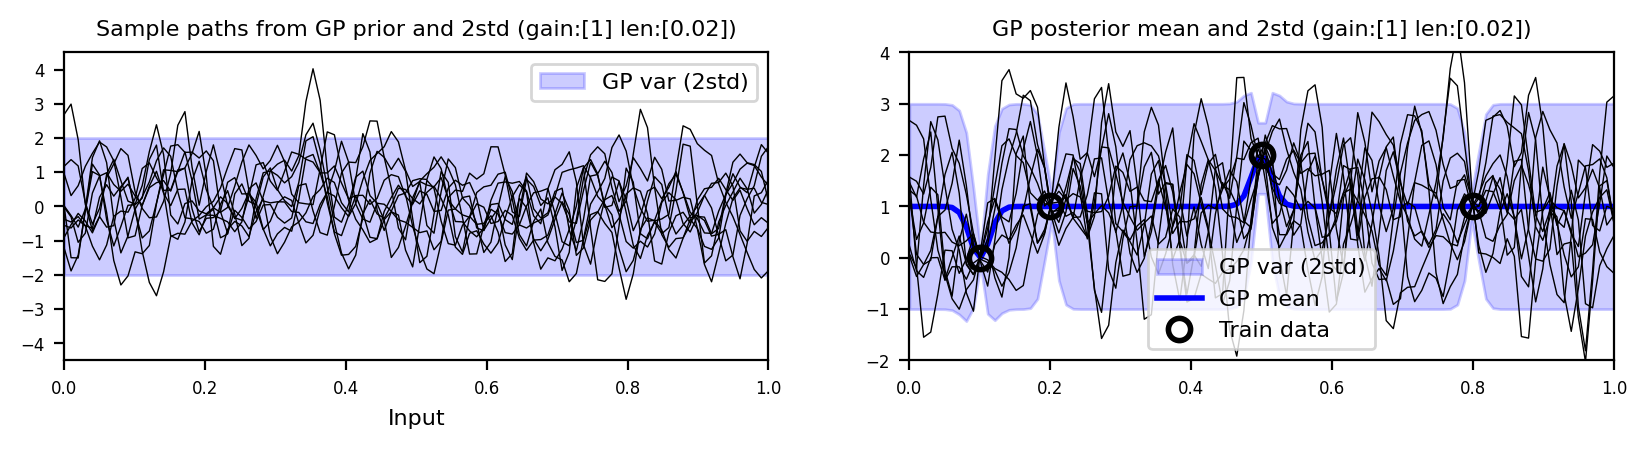

In [3]:
t_data = np.array([[0.1,0.2,0.5,0.8]]).T
y_data = np.array([[0.0,1.0,2.0,1.0]]).T
L,N = 100,t_data.shape[0]
t_test = np.linspace(start=0,stop=1.0,num=L).reshape((-1,1))

for i_idx,(gain,len_val) in enumerate([(1,1),(1,1/2),(1,1/4),(4,1/4),(1,1/50)]):
    hyp = {'gain':gain,'len':len_val}
    # Compute kernel matrics
    K_test      = kernel_se(t_test,t_test,hyp=hyp) # [L x L]
    K_test_chol = np.linalg.cholesky(K_test+1e-8*np.eye(L,L)) # [L x L]
    K_data      = kernel_se(t_data,t_data,hyp=hyp) # [N x N]
    K_test_data = kernel_se(t_test,t_data,hyp=hyp) # [L x N]
    
    # Sample from GP prior
    n_sample = 10 # number of sample paths
    prior_sample_path = np.matmul(K_test_chol,np.random.randn(L,n_sample))
    var_prior_diag = np.diag(K_test) # [L]
    std_prior_diag = np.sqrt(var_prior_diag) # [L]
    
    # Gaussian process posterior
    inv_K_data = np.linalg.inv(K_data+1e-8*np.eye(N)) # [N x N]
    mu_y = np.mean((y_data))
    mu_test = K_test_data @ inv_K_data @ (y_data-mu_y) + mu_y
    K_posterior = K_test - K_test_data @ inv_K_data @ K_test_data.T # [L x L]
    var_posterior_diag = np.diag(K_posterior) # [L]
    std_posterior_diag = np.sqrt(var_posterior_diag) # [L]
    K_posterior_chol = np.linalg.cholesky(K_posterior+1e-8*np.eye(L,L)) # [L x L]
    posterior_sample_path = np.matmul(K_posterior_chol,np.random.randn(L,n_sample))
    
    # Plot sample paths
    plt.figure(figsize=(10,2))
    plt.subplot(1,2,1)
    plt.fill_between(t_test.reshape(-1), 
                    (np.zeros(L)-2*std_prior_diag),
                    (np.zeros(L)+2*std_prior_diag),
                    alpha=0.2,color='b',label='GP var (2std)')
    plt.plot(t_test,prior_sample_path,'-',lw=1/2,color='k')
    plt.xlabel('Input',fontsize=8); 
    plt.xlim([0,1]); plt.ylim([-4.5,+4.5])
    plt.legend(fontsize=8)
    plt.title('Sample paths from GP prior and 2std (gain:[%d] len:[%.2f])'%
              (hyp['gain'],hyp['len']),fontsize=8)
    # Plot GPR
    plt.subplot(1,2,2)
    plt.fill_between(t_test.reshape(-1), 
                    (mu_test.reshape(-1)-2*std_posterior_diag),
                    (mu_test.reshape(-1)+2*std_posterior_diag),
                    alpha=0.2,color='b',label='GP var (2std)')
    plt.plot(t_test,mu_test,linestyle='-',color='b',lw=2,label='GP mean')
    plt.plot(t_data.squeeze(),y_data.squeeze(),linestyle='none',
             marker='o',ms=8,mec='k',mew=2,mfc='none',label='Train data')
    plt.plot(t_test,mu_test+posterior_sample_path,'-',lw=1/2,color='k')
    plt.xlim([0,1]); plt.ylim([-2,+4])
    plt.legend(fontsize=8)
    plt.title('GP posterior mean and 2std (gain:[%d] len:[%.2f])'%
              (hyp['gain'],hyp['len']),fontsize=8)
    plt.show()